#### The purpose of this notebooks is to test whether the single trial beta maps produce a similar maps as the SPM univariate analysis

Method:
* 1) convert .nii to .npy : scripts/step10_nilearn/glm/cue-high_GT_cue-low/glm_numpify_ttest.py
* 2) average .npy per subject (session and run concatenated): scripts/step10_nilearn/glm/cue-high_GT_cue-low/numpy_ttest_cue.py
* 3) plot the end product here.

In [1]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img, new_img_like
from nilearn import image, plotting
import argparse
import matplotlib.pyplot as plt
from surfplot import Plot
from matplotlib import cm
import neuromaps
import nibabel as nib
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


In [2]:
def plot_surf(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh, size=(200, 600), zoom=1.6, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

In [3]:
def plot_surf_box(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh) #, size=(600, 600)) #, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

# task-pain

In [4]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_stimintensity-high.npy"))

In [5]:
suballLv.shape

(110, 458294)

In [6]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    )

In [7]:
x,y,z=ref_img.shape
H = []
L = []
for index in range(suballLv.shape[0]):
    # apply masker onto numpy array (shape of #subjects x voxels)
        
    H.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )
    


In [8]:
fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(110, 98053)


In [9]:
(fmri_masked_stimhigh - fmri_masked_stimlow).shape

(110, 98053)

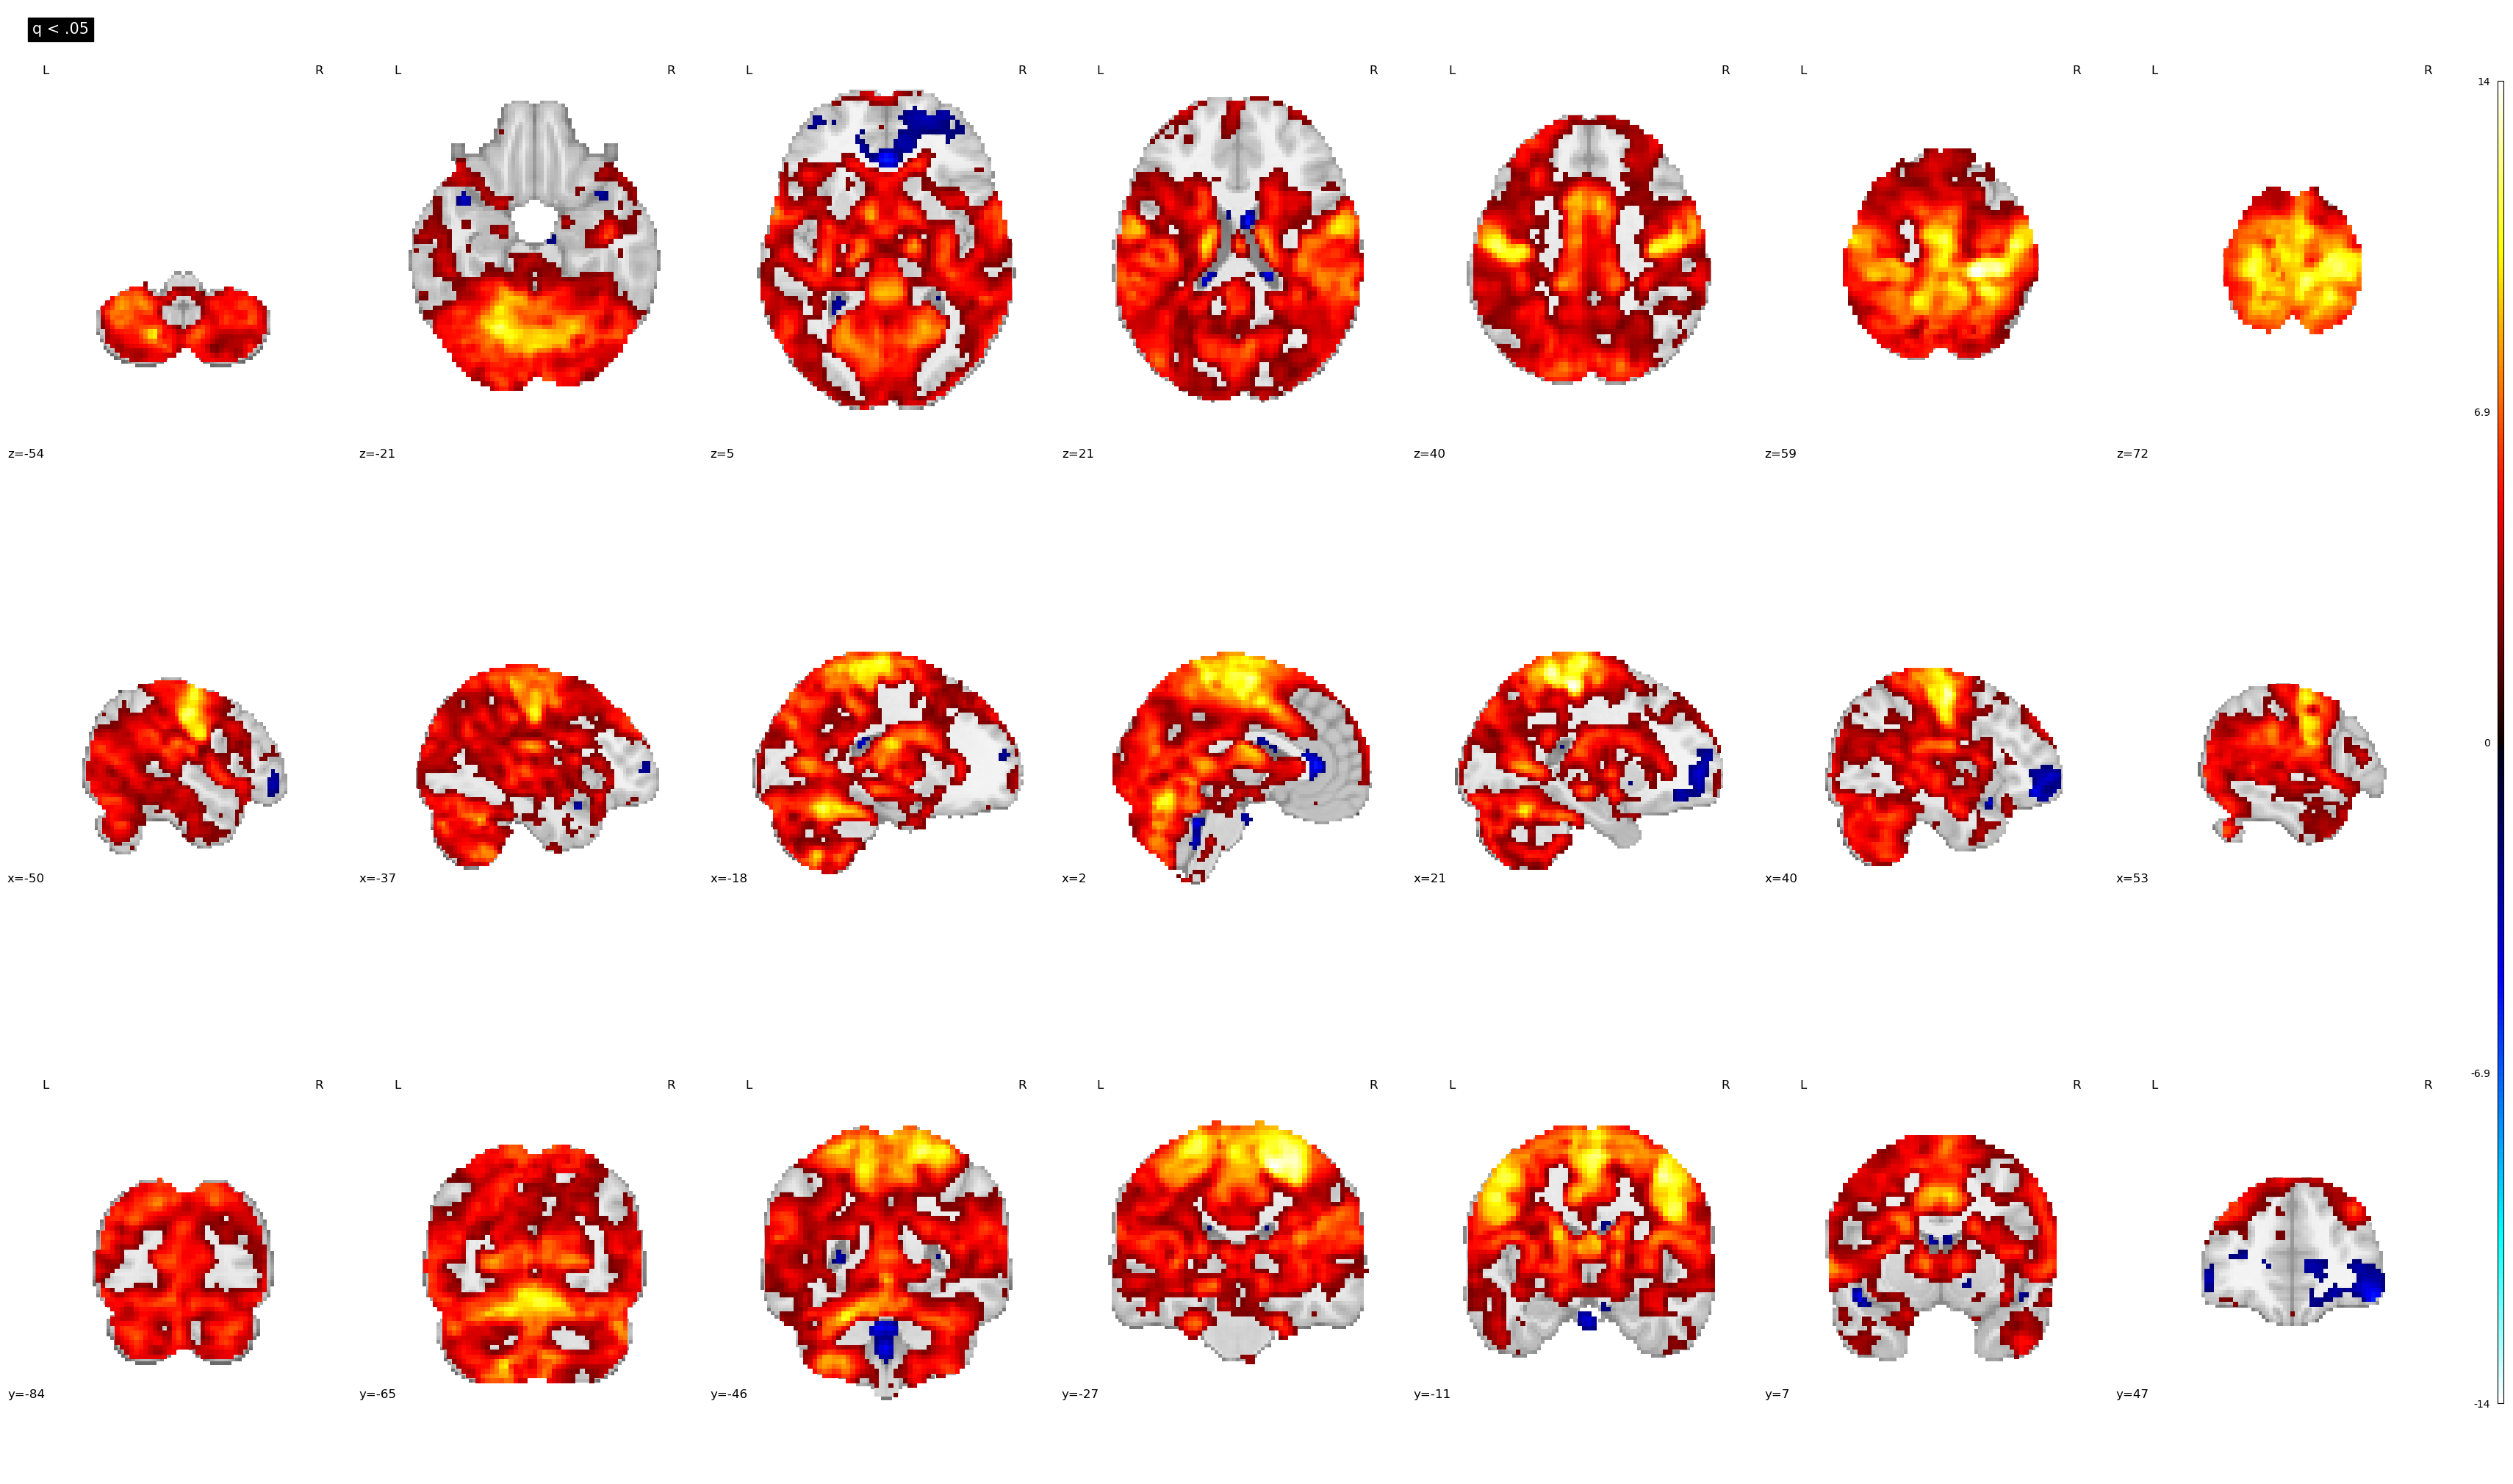

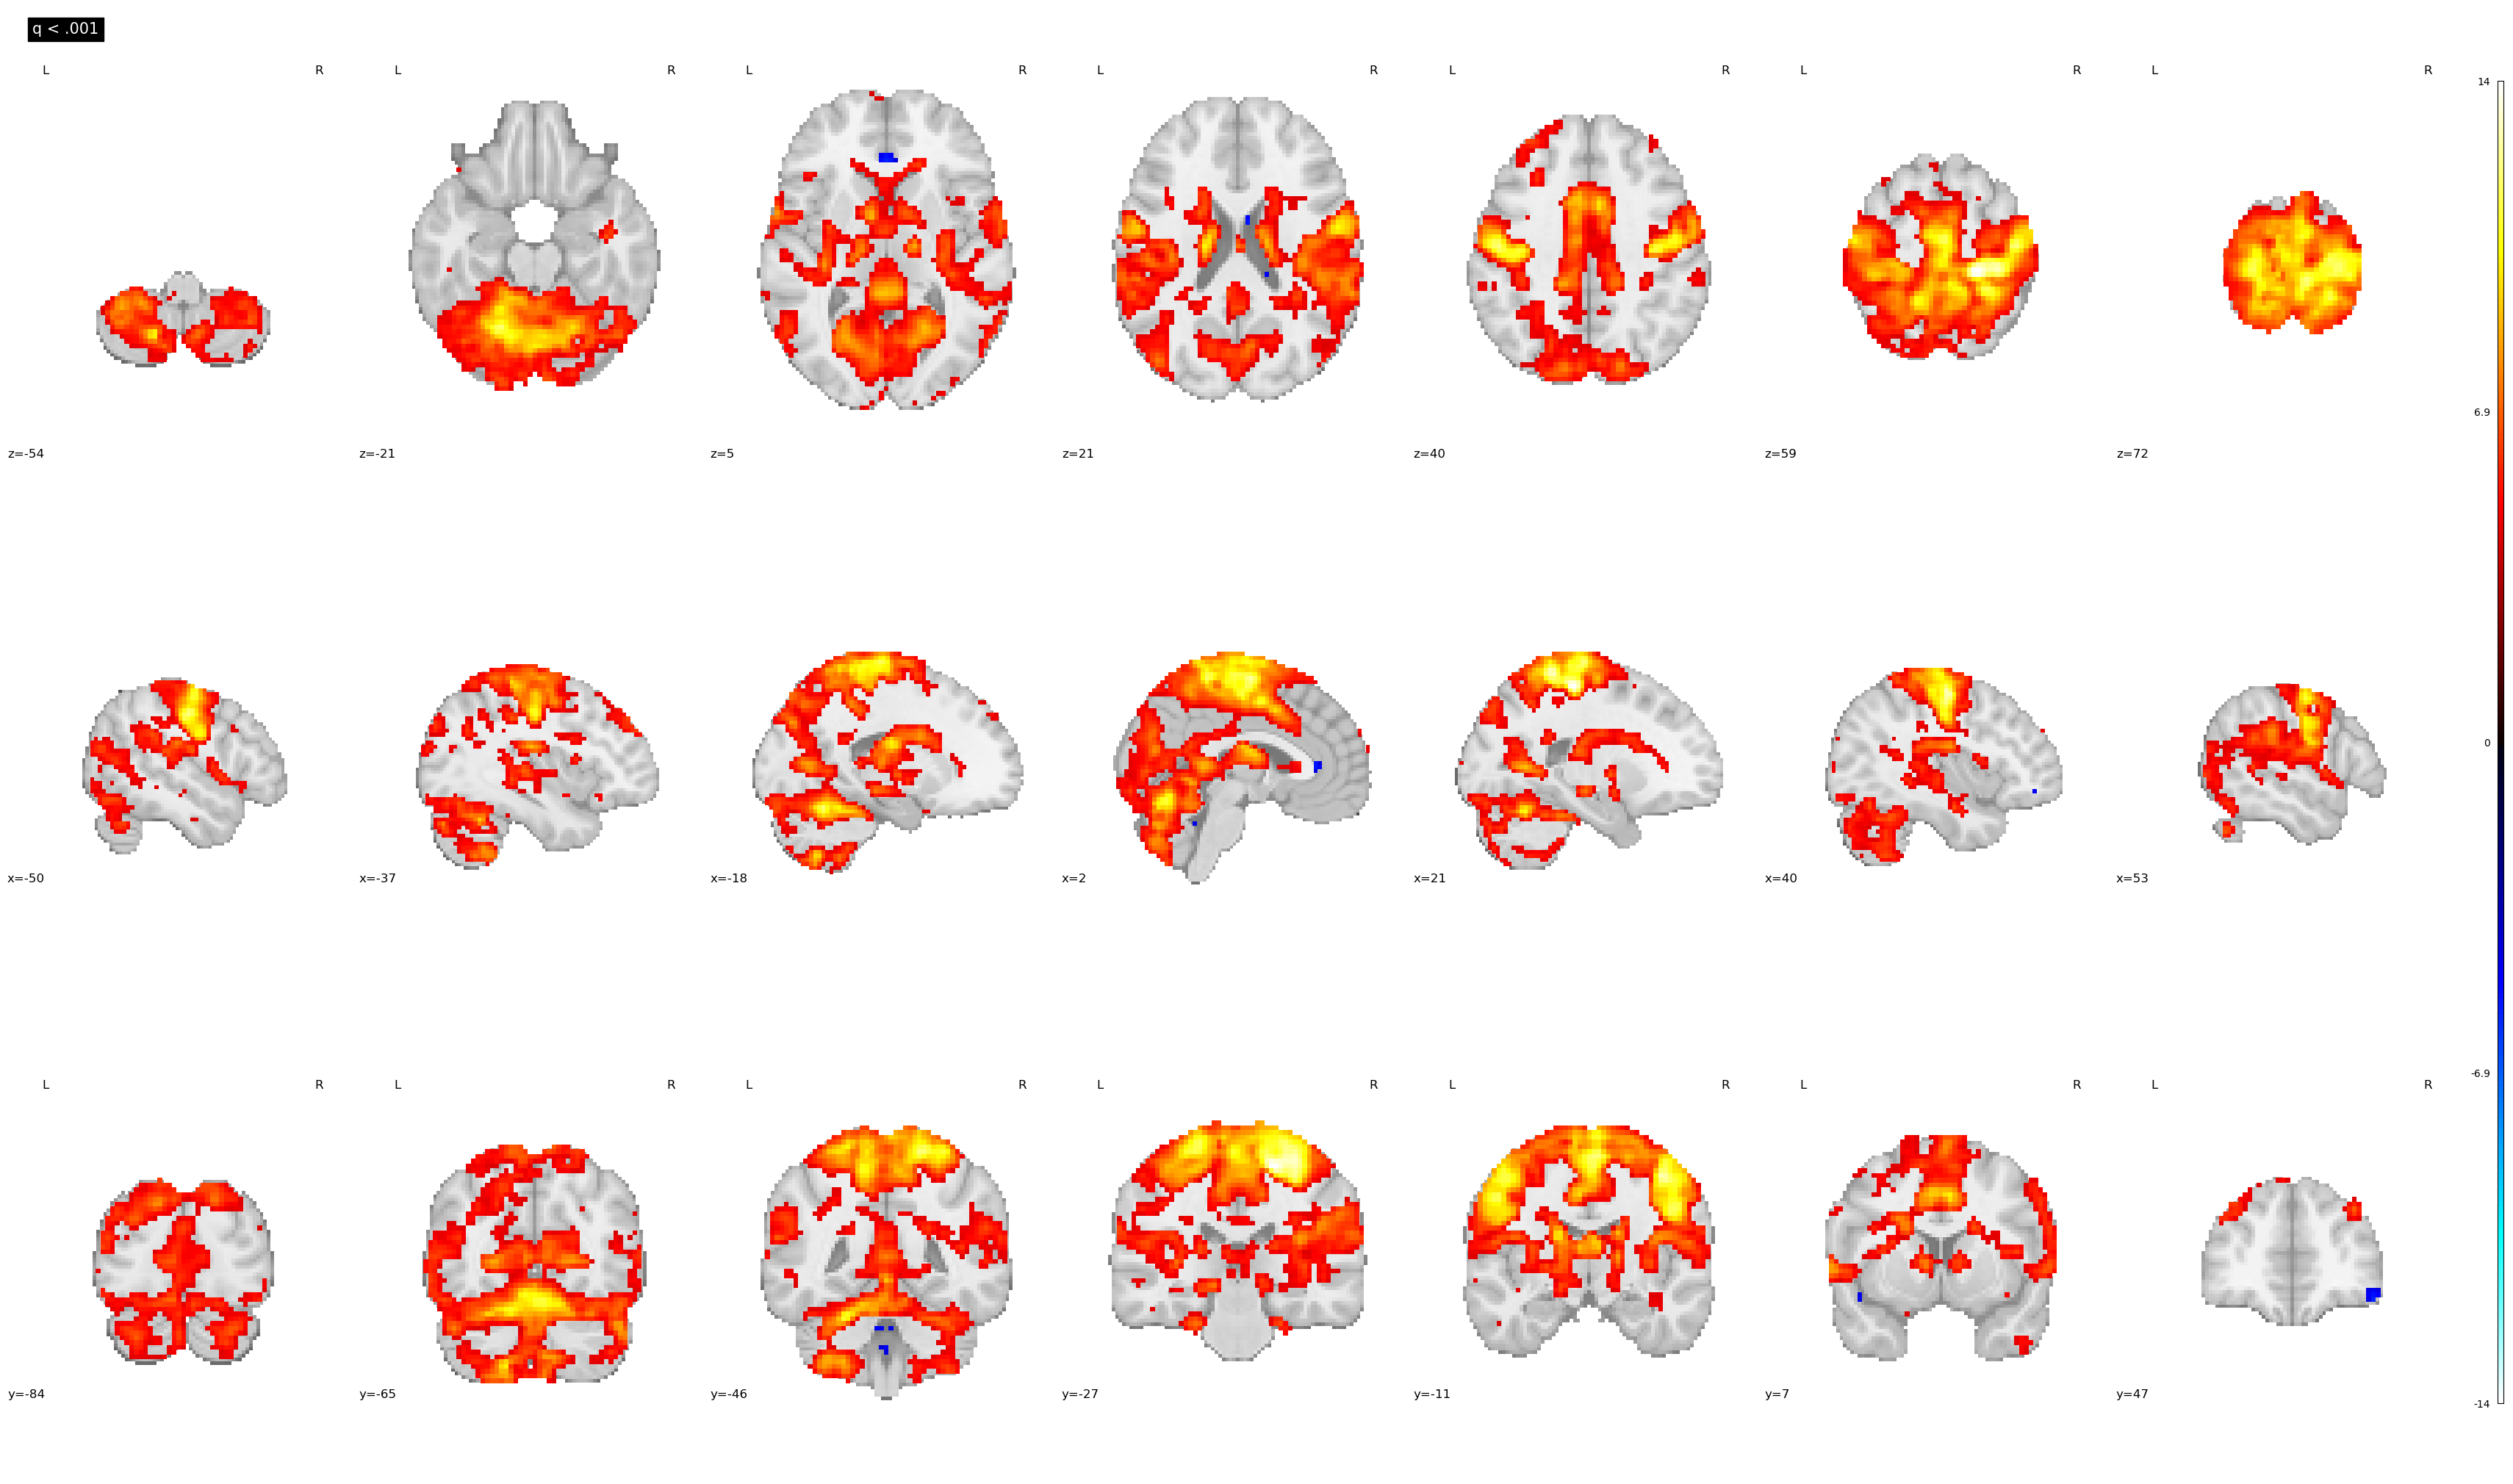

In [10]:
tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
unthres_tmap = nifti_masker.inverse_transform(tvalues)

result_map = np.zeros(fmri_masked_stimhigh.shape[1])
result_map[qvalues < .05] = tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)

result_map_001 = np.zeros(fmri_masked_stimhigh.shape[1])
result_map_001[qvalues < .0001] = tvalues[qvalues < .0001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)

plotting.plot_stat_map(con_tmap,  display_mode = 'mosaic', title = 'q < .05')
plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')
# plotting.plot_stat_map(con_bmap, threshold = 1, display_mode = 'mosaic')
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename('singletrial-tmap_task-pain_p-unthres.nii.gz')
con_tmap.to_filename('singletrial-tmap_task-pain_q-05.nii.gz')
con_tmap_001.to_filename('singletrial-tmap_task-pain_q-001.nii.gz')

# vicarious

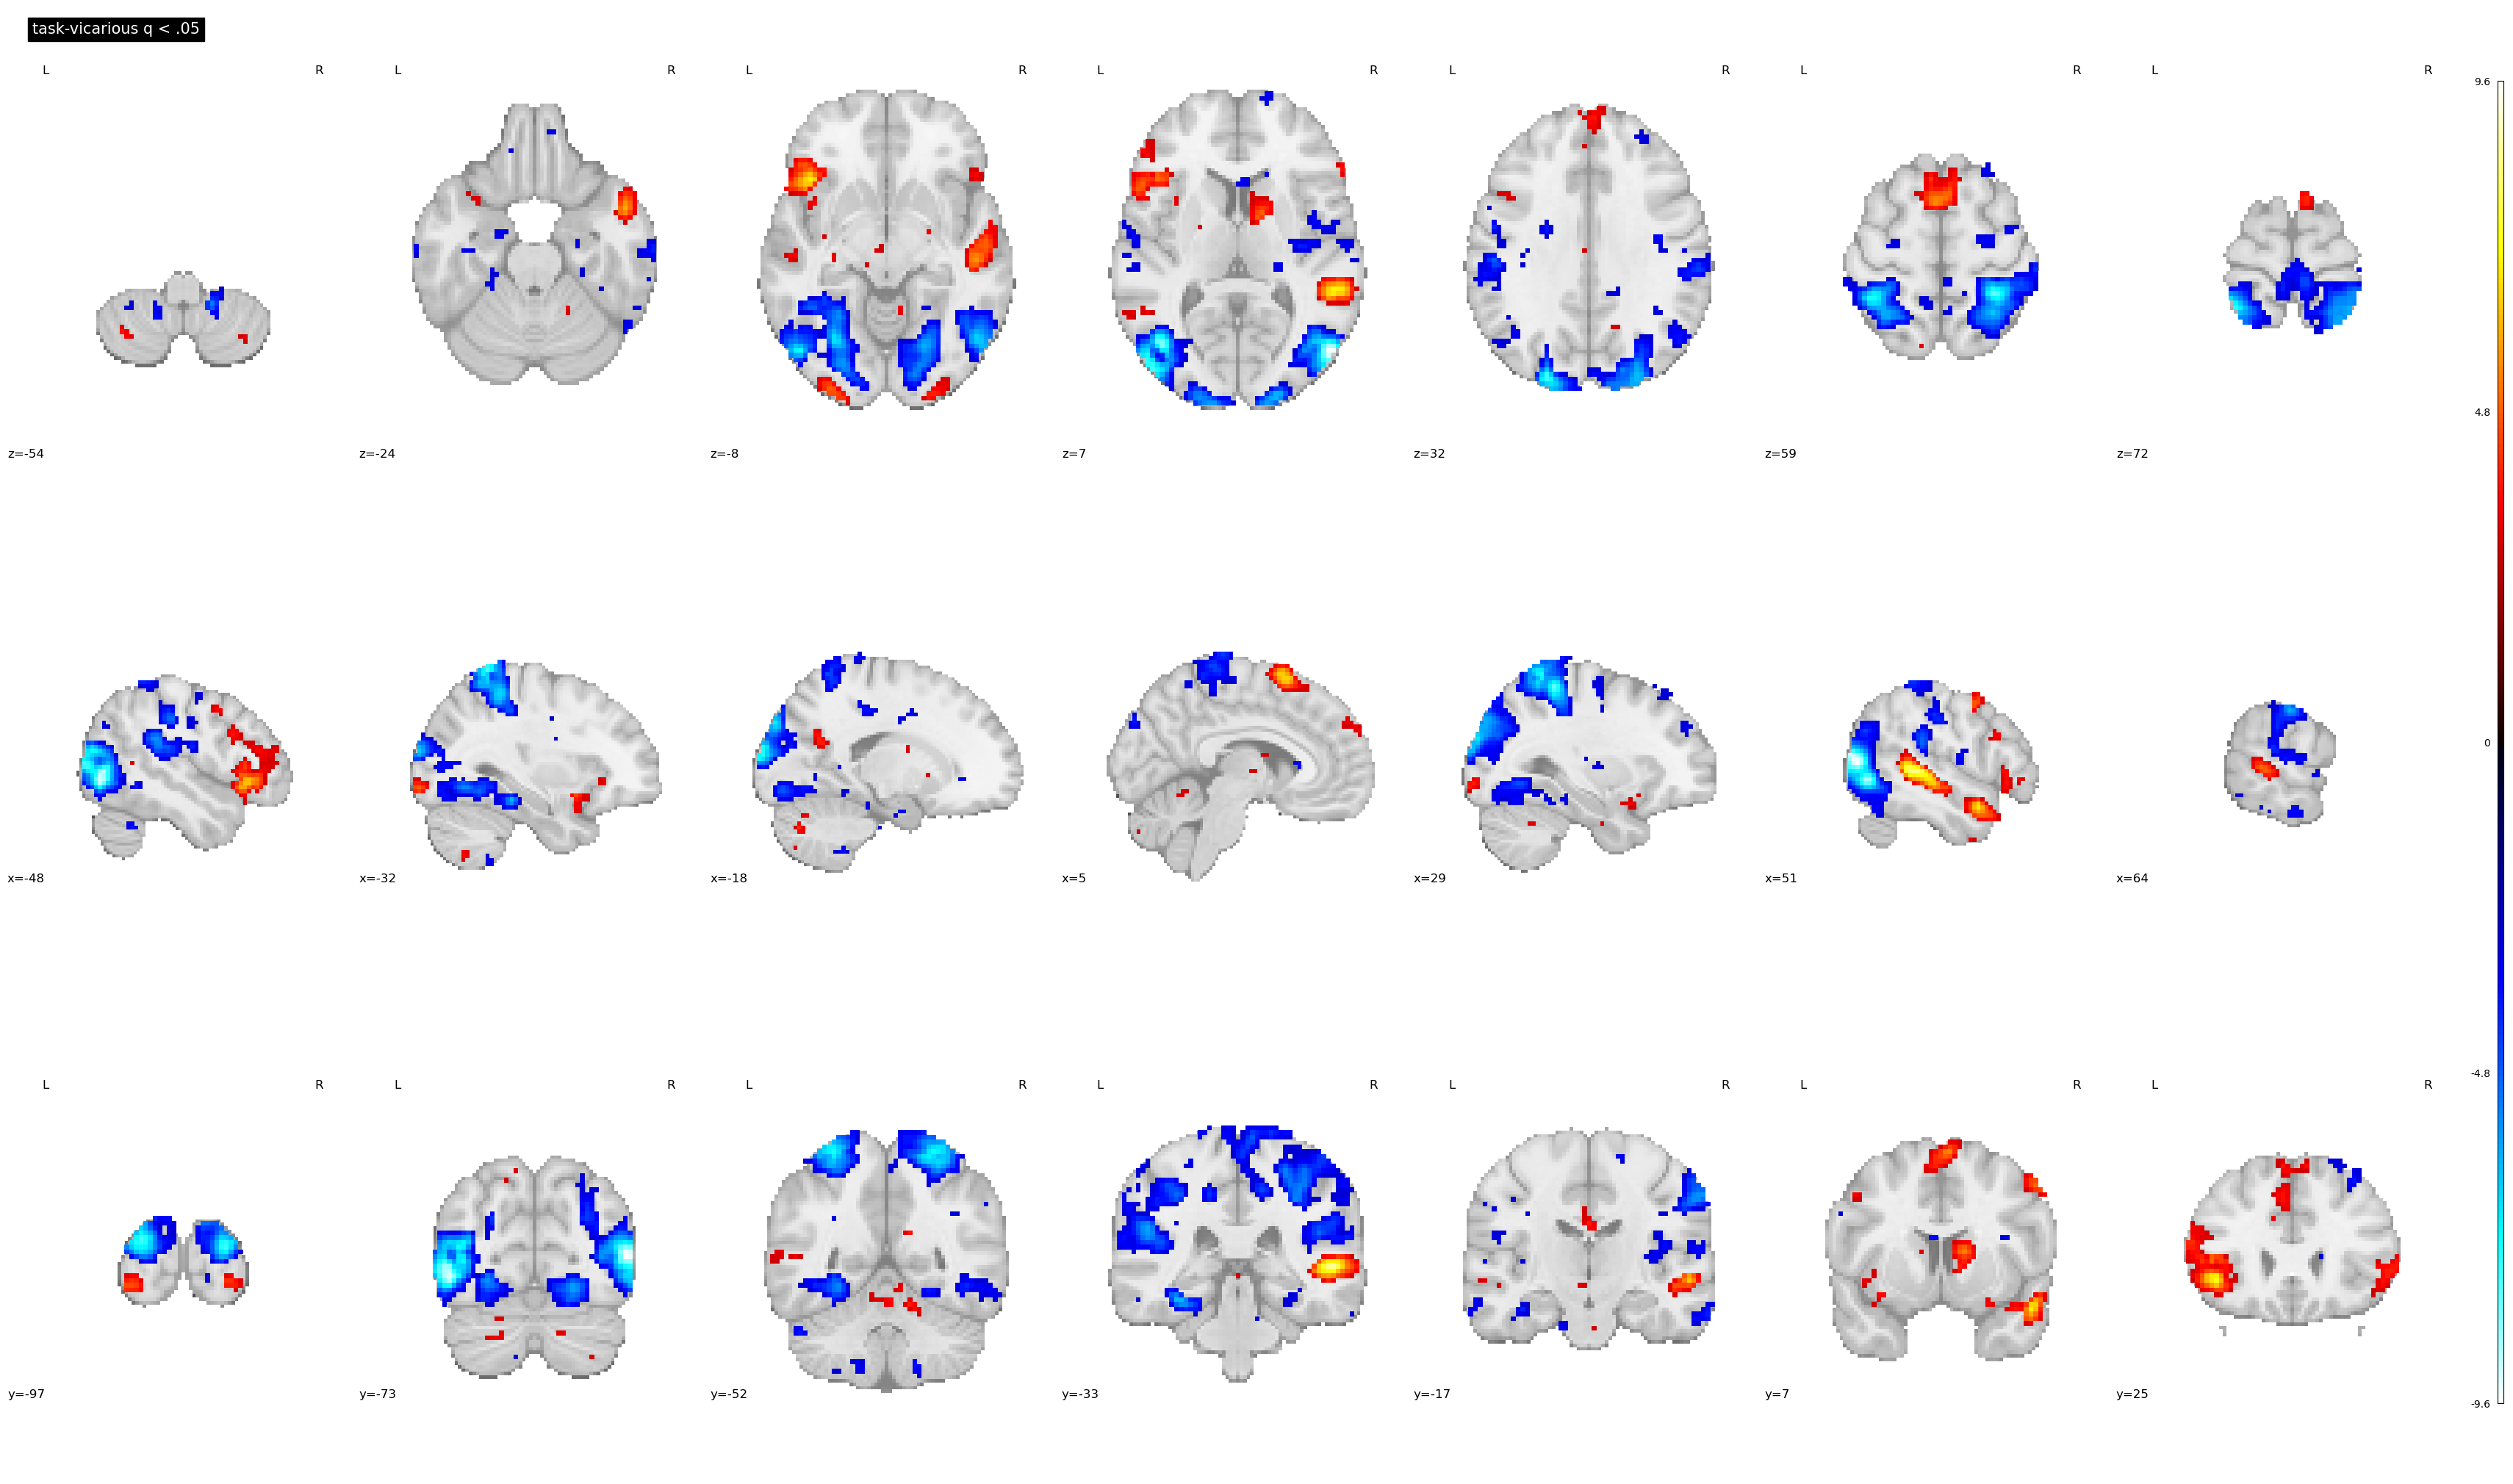

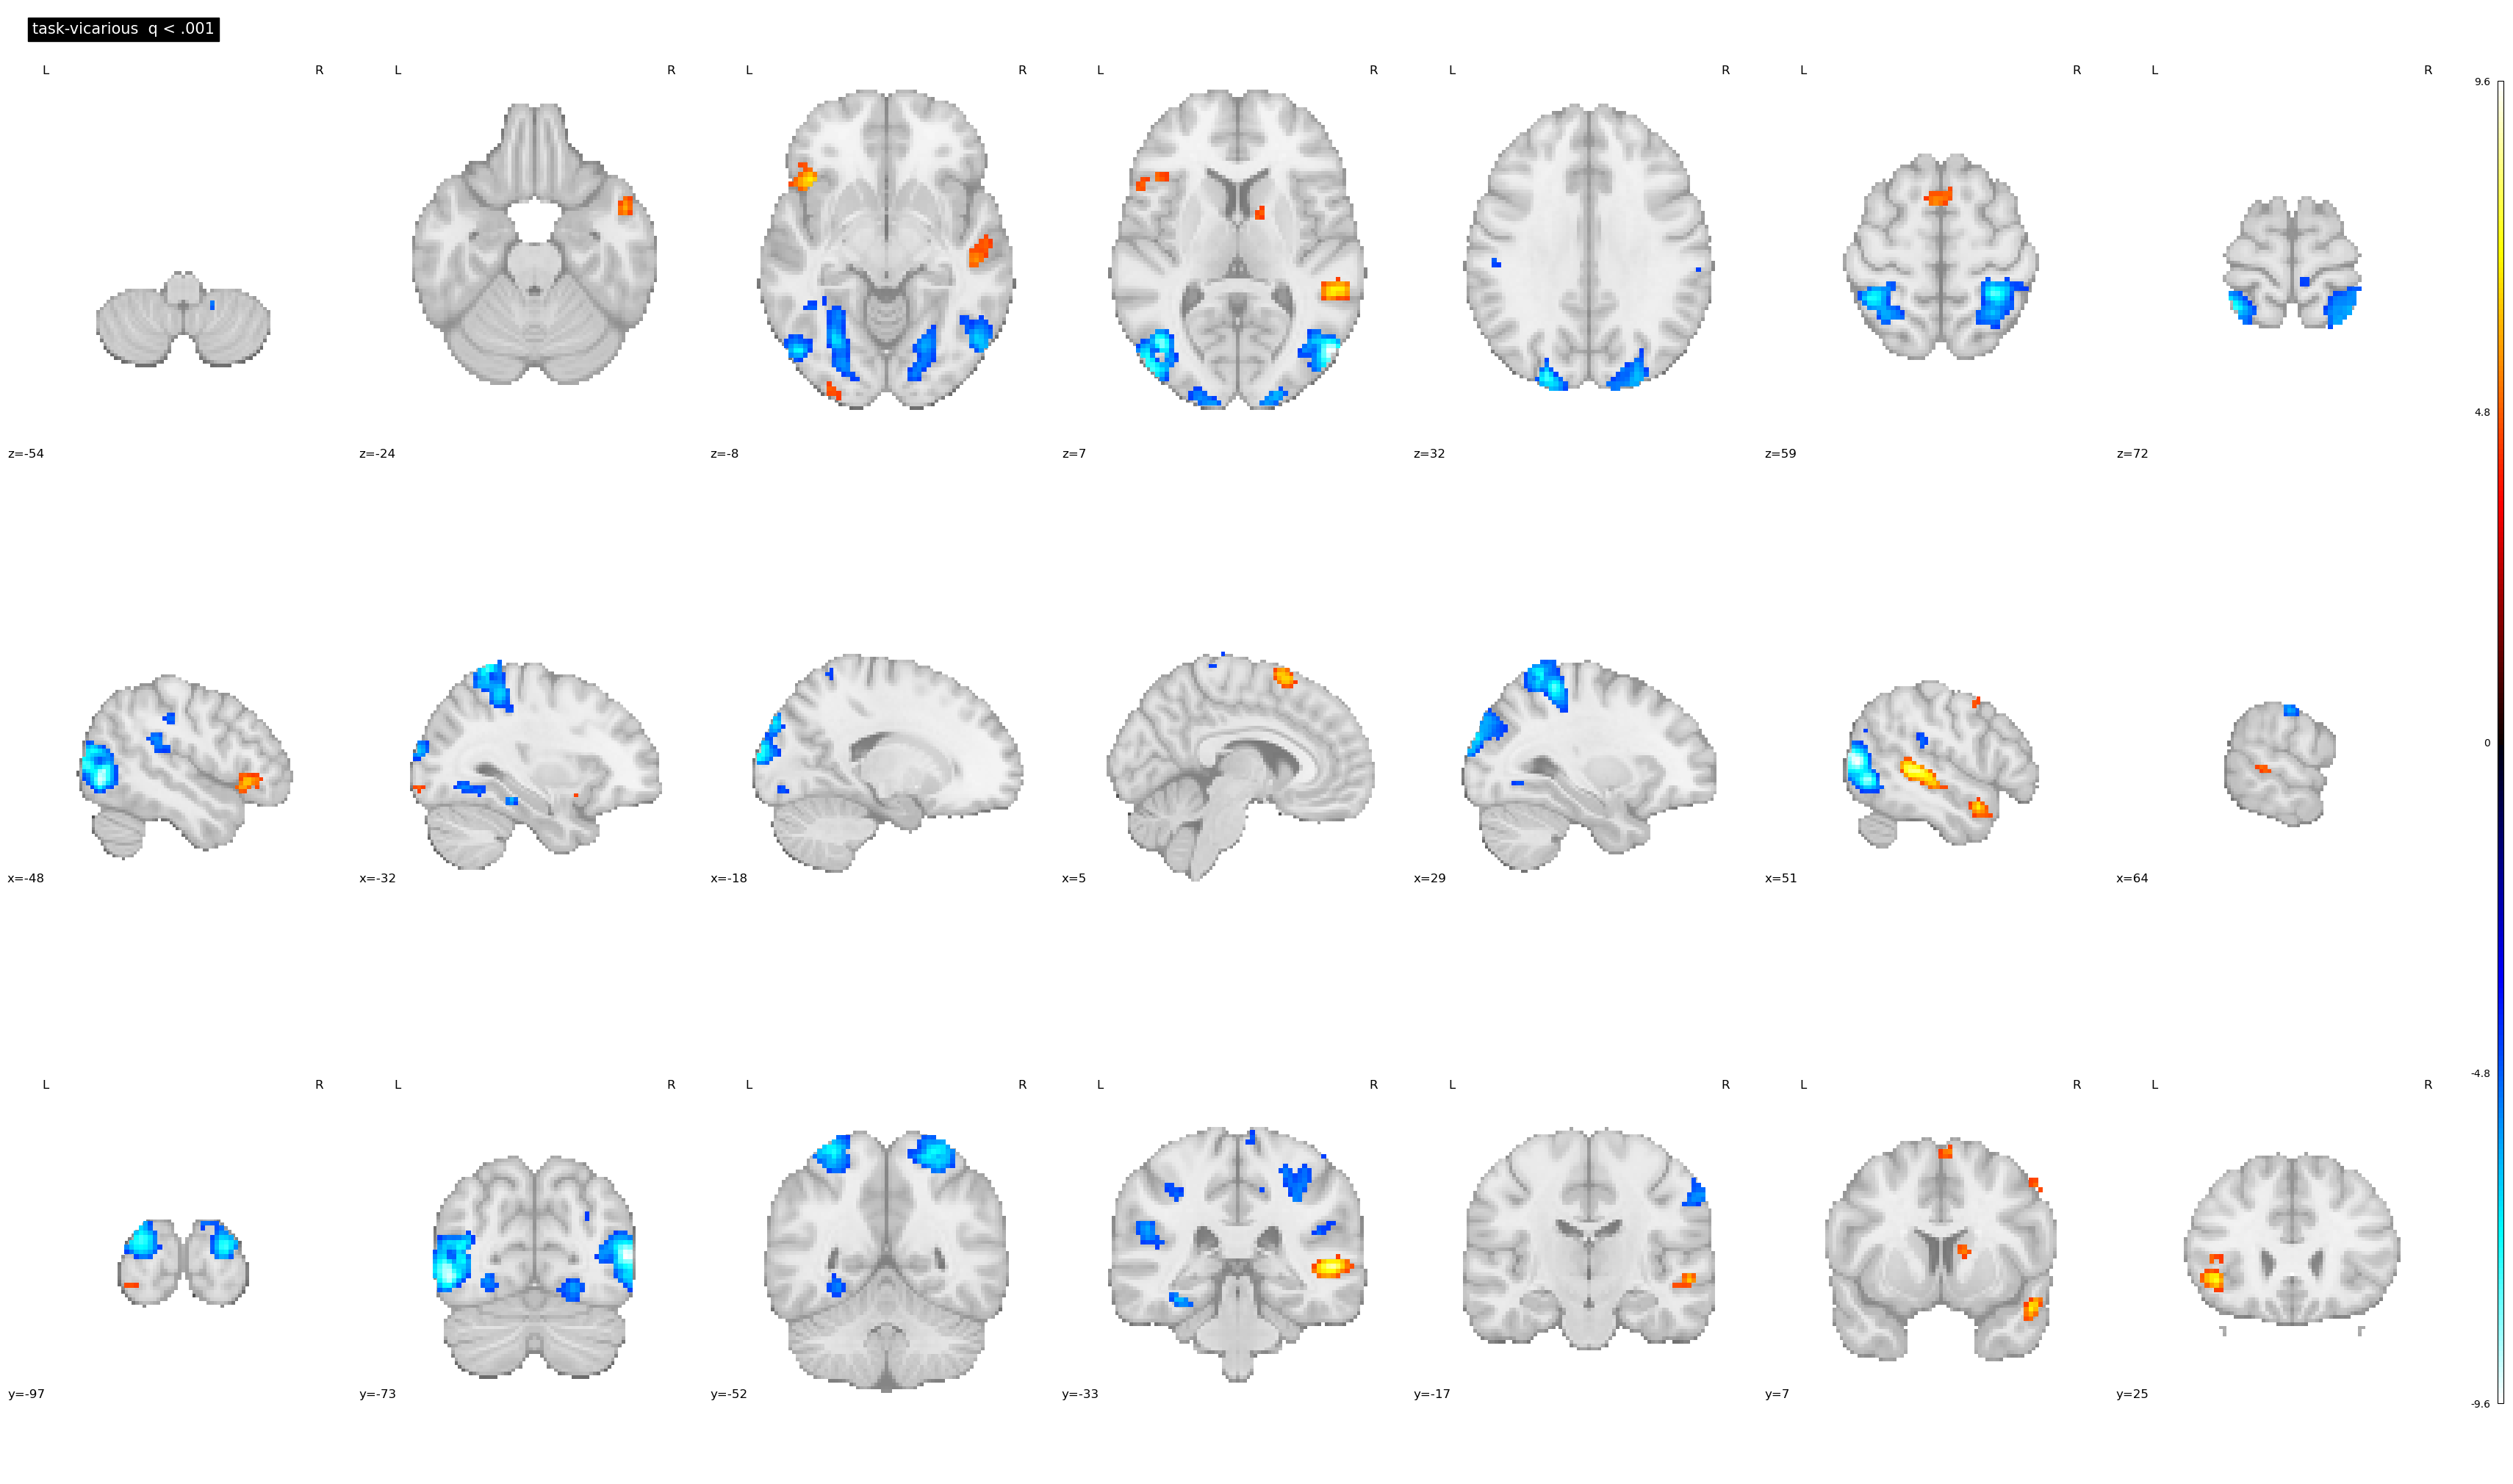

In [12]:
# vicarious
taskname = 'vicarious'
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = f'task-{taskname} q < .05')
plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = f'task-{taskname}  q < .001')

# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_q-001.nii.gz')

In [13]:
print(f"min: {np.min(con_tmap.get_fdata())}")
print(f"max: {np.max(con_tmap.get_fdata())}")
print(f"mean: {np.mean(con_tmap.get_fdata())}")

min: -7.99166474799705
max: 15.719677434507075
mean: 0.7907218503833677


In [14]:
fslr_left_medial.darrays[0].data * stimP_lh

NameError: name 'fslr_left_medial' is not defined

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_98593/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


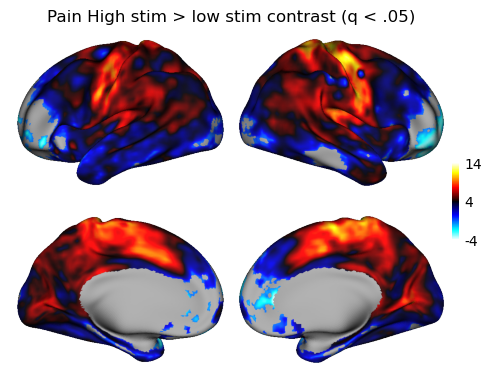

: 

In [ ]:
taskname = 'pain'
stimHgtL_P = neuromaps.transforms.mni152_to_fslr('singletrial-tmap_task-pain_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
fslr_left_medial = nib.load(surfaces['medial'].L)
fslr_right_medial = nib.load(surfaces['medial'].R)
masked_stimP_lh = fslr_left_medial.darrays[0].data * stimP_lh
masked_stimP_rh = fslr_right_medial.darrays[0].data * stimP_rh
plot_surf_box(surfaces, 
          surf_lh=masked_stimP_lh, 
          surf_rh= masked_stimP_rh, 
          title=f'Pain High stim > low stim contrast (q < .05)')

# task-vicarious

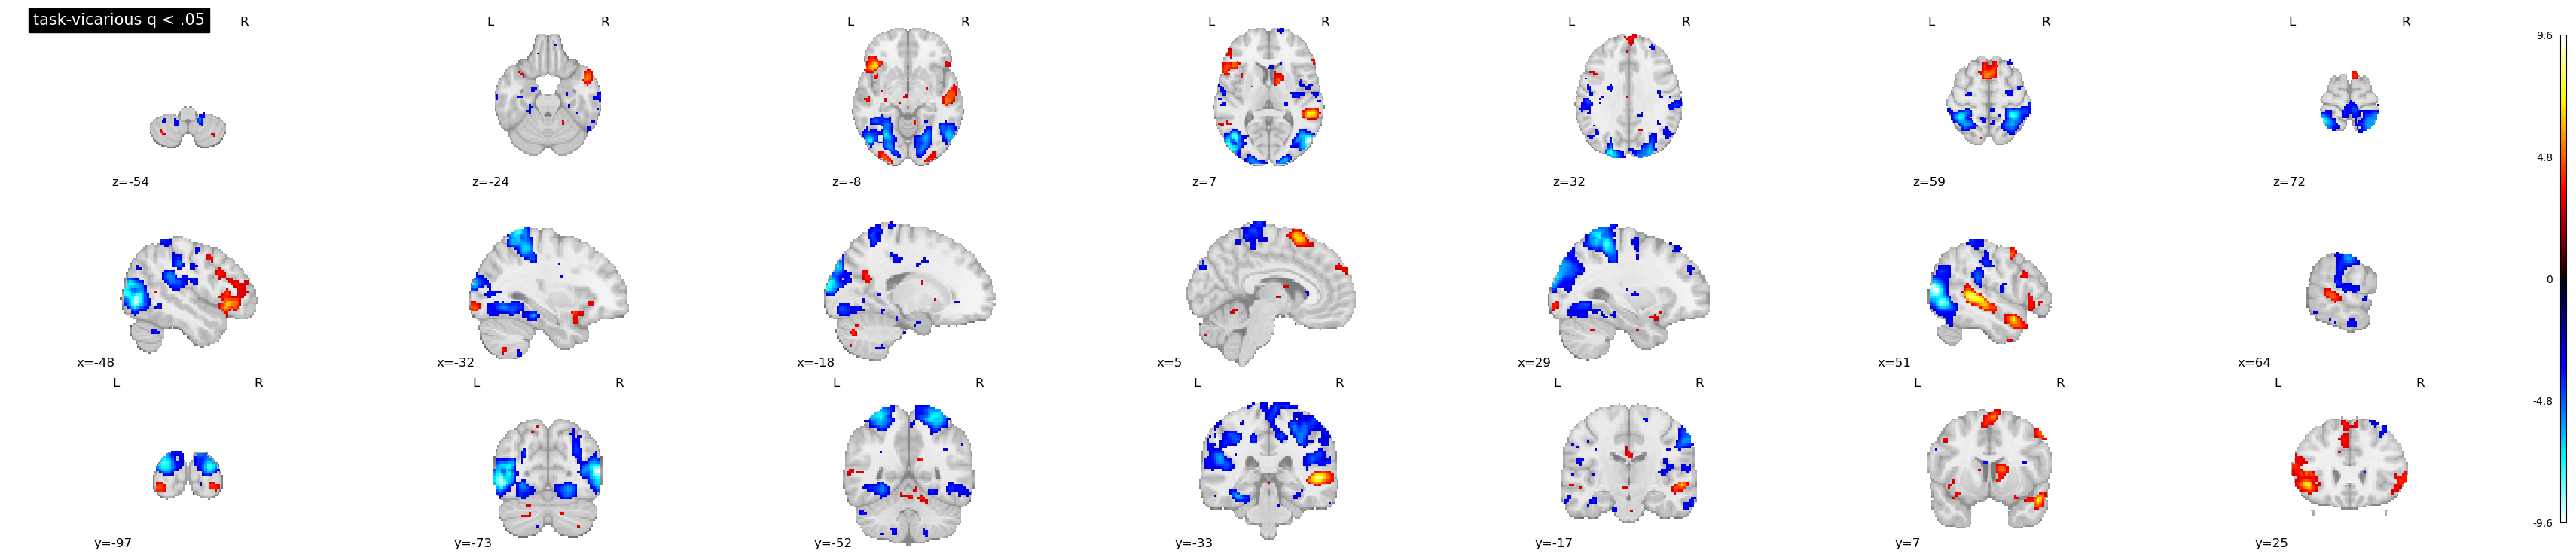

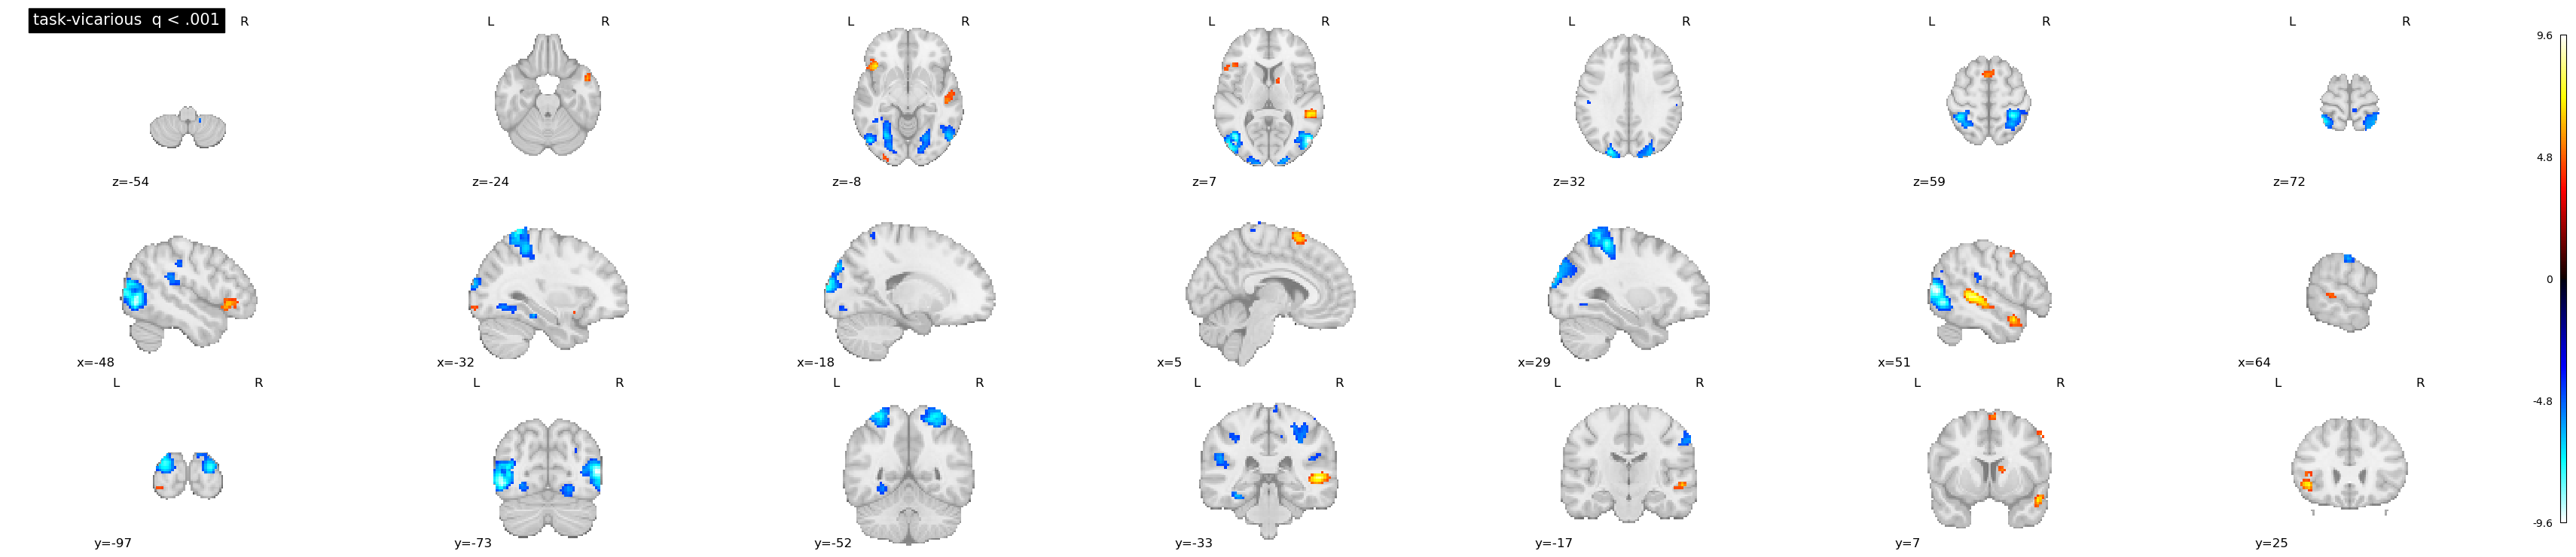

In [ ]:
# vicarious
taskname = 'vicarious'
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = f'task-{taskname} q < .05')
plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = f'task-{taskname}  q < .001')

# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_q-001.nii.gz')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_98593/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


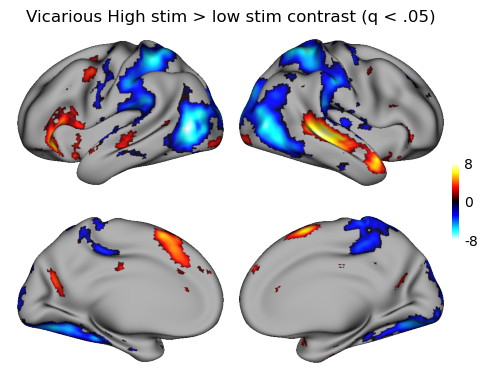

In [ ]:
taskname = 'vicarious'
stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High stim > low stim contrast (q < .05)')

# task-cognitive

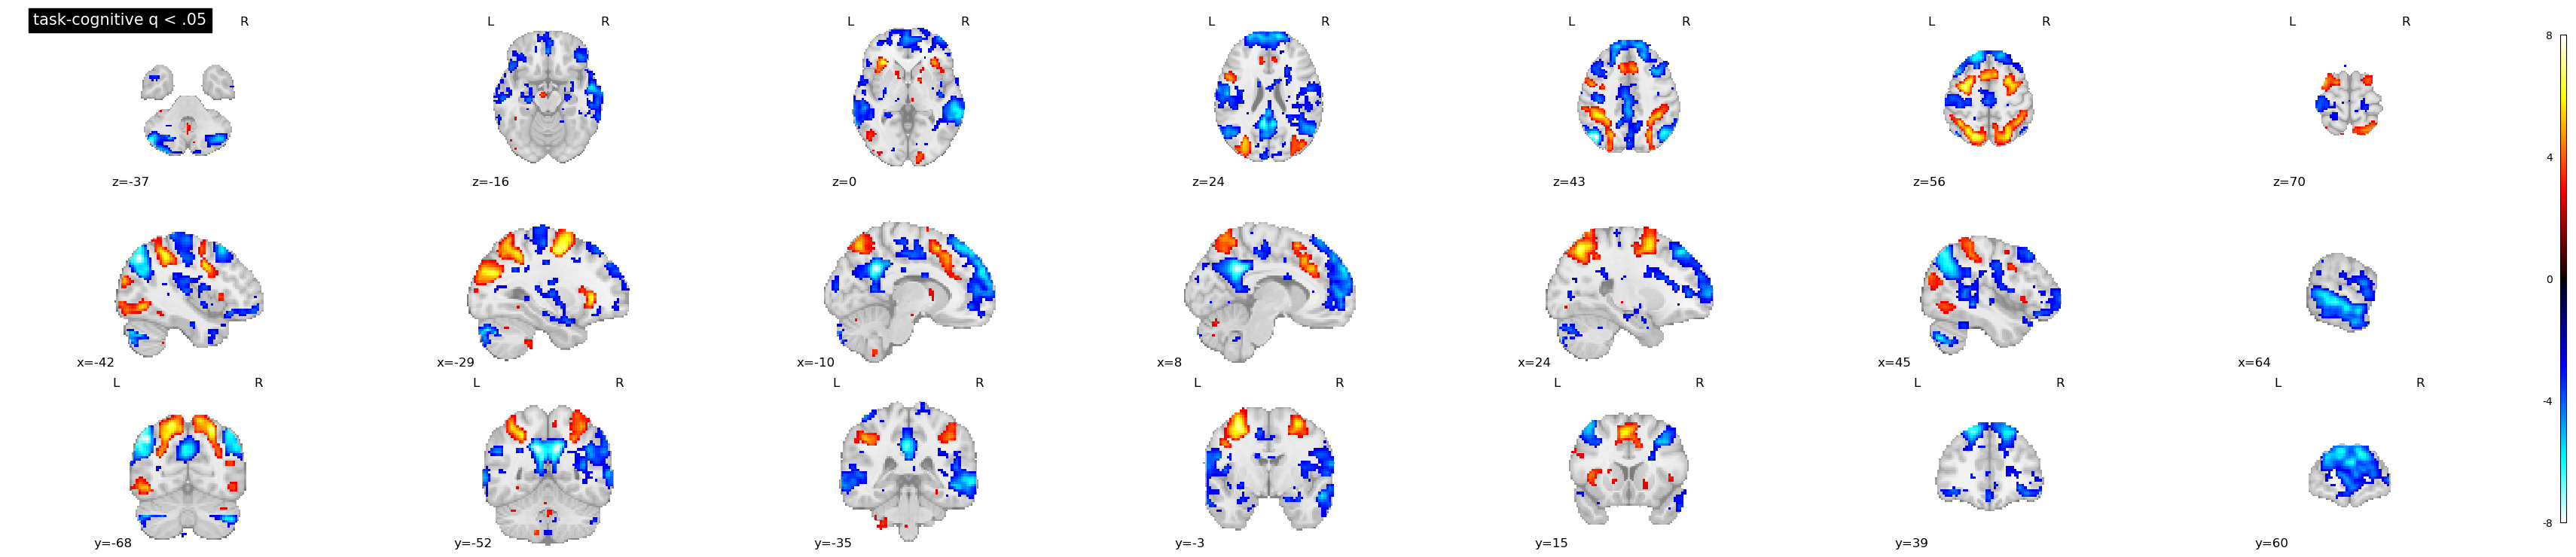

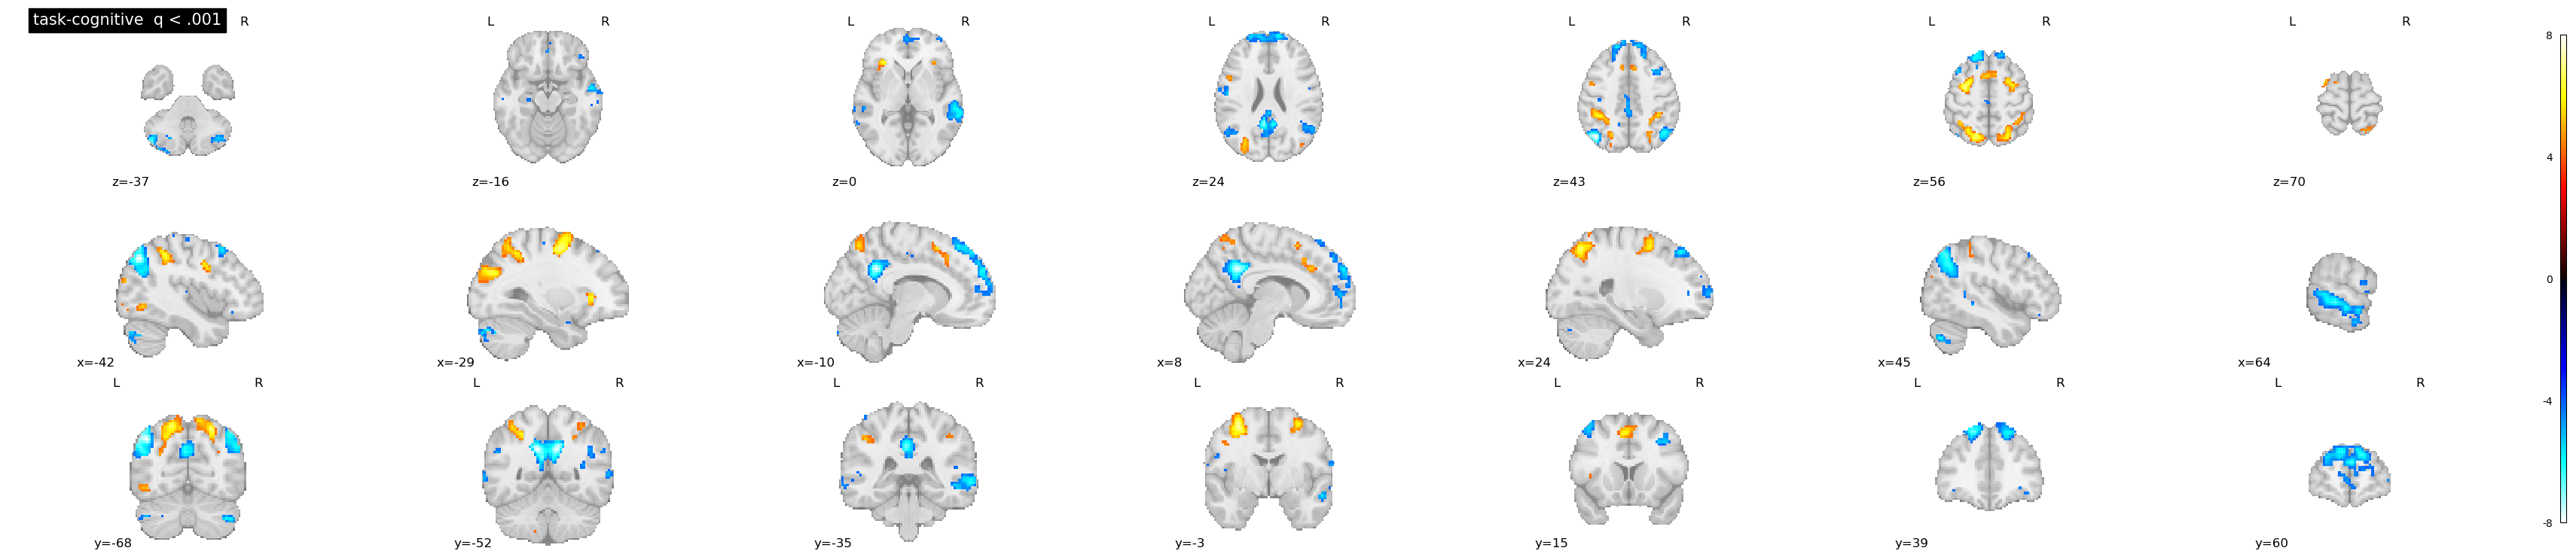

In [ ]:
#
# vicarious
taskname = 'cognitive'
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-{taskname}_event-stimulus_stimintensity-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = f'task-{taskname} q < .05')
tmap_001 = plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = f'task-{taskname}  q < .001')
# tmap_001.title(title = f'task-{taskname}  q < .001', size=30)

# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_q-001.nii.gz')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_98593/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


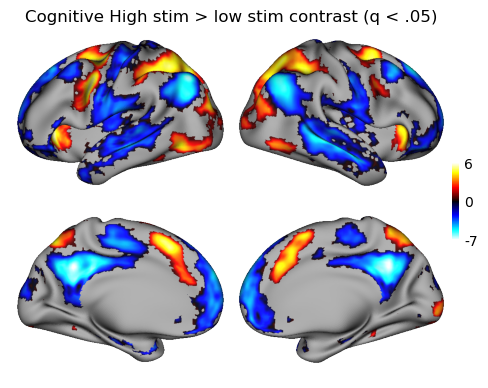

In [ ]:

stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High stim > low stim contrast (q < .05)')